#Mounting Google Drive


In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

# Importing the libraries

In [ ]:
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import optimizers, losses, activations, models

# Get data:

In [ ]:
def get_data():
    if 'Dataset' in os.listdir():
        print('Dataset already exists')
    else:
        # print('Downloading the data...')
        # !gdown --id 1WBhCaHNG0Uh20MNsV3l9kjVXqzFilBQL
        # print('Dataset downloaded!')
        # print('Copying Zip file to your Drive..')
        # !cp /content/split-VietnameseFoods-30.tar.gz 'drive/My Drive/VietnameseFoods-30'
        # print('Copying done!')
        print('Copying the data...')
        !cp /content/drive/MyDrive/DeepLearning/Final/Model_Transfer/InceptionV3/split-mini-VietnameseFoods-30.tar.gz ./
        print('Dataset copied!')
        print('Extracting data..')
        !tar -xzvf split-mini-VietnameseFoods-30.tar.gz
        print('Extraction done!')
        print('Removing Zip file...')
        #os.remove('./split-VietnameseFoods-30.tar.gz')
        print('Done!')


get_data()

# Read data

In [ ]:
data_train = pathlib.Path("/content/Dataset/Training dataset")
data_val = pathlib.Path("/content/Dataset/Validation dataset")
data_test = pathlib.Path("/content/Dataset/Test dataset")

In [ ]:
data_test

PosixPath('/content/Dataset/Test dataset')

In [ ]:
train_dir = './Dataset/Training dataset'
val_dir = './Dataset/Validation dataset'
test_dir = './Dataset/Test dataset'
BATCH_SIZE = 128
IMG_SIZE = (224, 224)

In [ ]:
image_train = len(list(data_train.glob('*/*.jpg')))
image_val = len(list(data_val.glob('*/*.jpg')))
image_test = len(list(data_test.glob('*/*.jpg')))
print('Train:',image_train,'Val:', image_val,'Test:', image_test)

Train: 3513 Val: 508 Test: 1018


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  image_size = IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 3513 files belonging to 30 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_val,
  image_size = IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 508 files belonging to 30 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_test,
  image_size = IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 1018 files belonging to 30 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Bánh bèo', 'Bánh bột lọc', 'Bánh canh', 'Bánh căn', 'Bánh chưng', 'Bánh cuốn', 'Bánh giò', 'Bánh khọt', 'Bánh mì', 'Bánh pía', 'Bánh tét', 'Bánh tráng nướng', 'Bánh xèo', 'Bánh đúc', 'Bún bò Huế', 'Bún mắm', 'Bún riêu', 'Bún thịt nướng', 'Bún đậu mắm tôm', 'Canh chua', 'Cao lầu', 'Cá kho tộ', 'Cháo lòng', 'Cơm tấm', 'Gỏi cuốn', 'Hủ tiếu', 'Mì quảng', 'Nem chua', 'Phở', 'Xôi xéo']


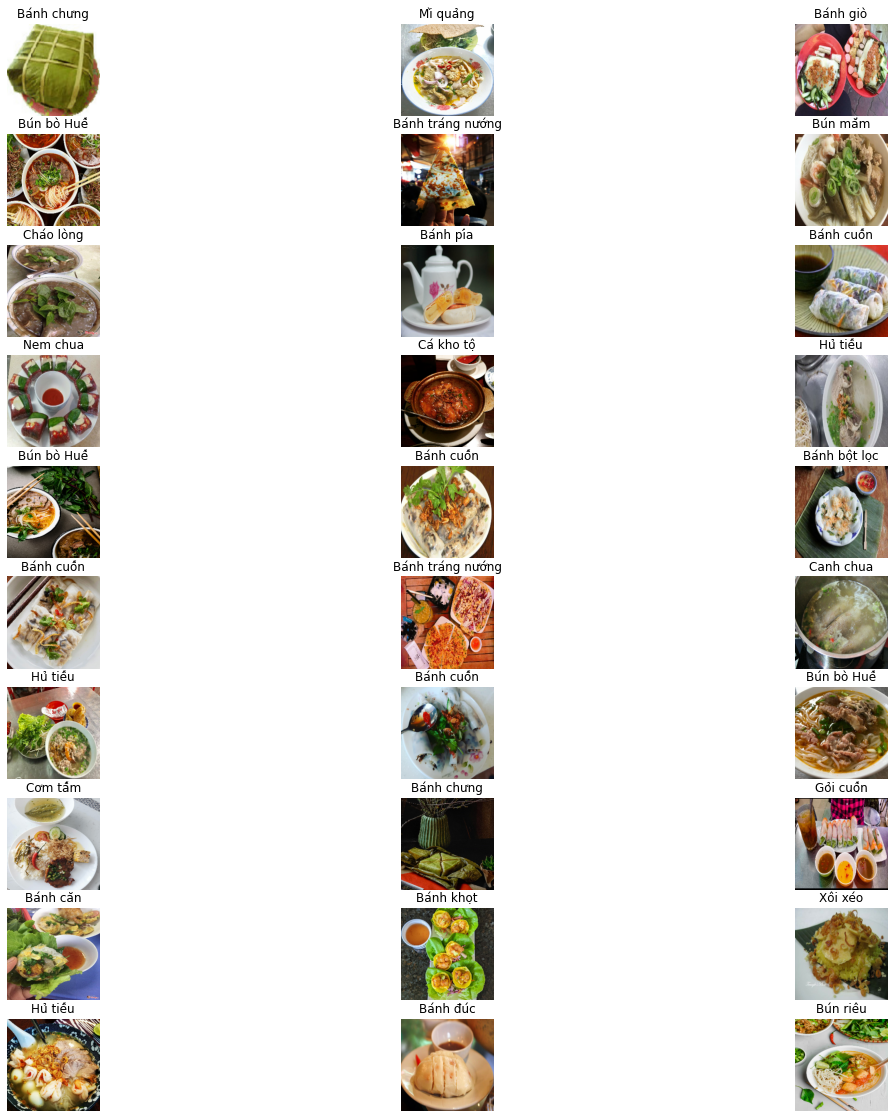

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(30):
    ax = plt.subplot(10, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(layers.GlobalAveragePooling2D())
add_model.add(layers.Dropout(0.5))
add_model.add(layers.Dense(1, 
                    activation='softmax'))

model = add_model
model.compile(loss='categorical_crossentropy', 
              optimizer = optimizers.SGD(lr=1e-4, 
                                       momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
 3/28 [==>...........................] - ETA: 3:52 - loss: 0.0000e+00 - accuracy: 0.0330

KeyboardInterrupt: ignored